In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

np.random.seed(1337)

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

## General Utility Functions For Data Processing

In [3]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

## Load Data and Create Train/Test Datasets

In [4]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

label_e_train = e_train['scaled_rl']
label_e_test = e_test['rl']

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create Alternate Encoding 

Each sequence gets a vector of scalars: in-frame starts, in-frame stops, out-of-frame starts, out-of-frame stops

In [5]:
def encode_counts(df, col='utr'):
    vectors = np.zeros([len(df),4])
    for i,seq in enumerate(df[col].values):  
        f1 = [ seq[j:j+3] for j in range(0, len(seq), 3) ]
        f2 = [ seq[j:j+3] for j in range(1, len(seq), 3) ]
        f3 = [ seq[j:j+3] for j in range(2, len(seq), 3) ]
        n_inf_start = f1.count('ATG')
        n_otf_start = f2.count('ATG') + f3.count('ATG')
        n_inf_stop = f1.count('TAA')+f1.count('TAG')+f1.count('TGA')
        n_otf_stop = f2.count('TAA')+f2.count('TAG')+f2.count('TGA')+f3.count('TAA')+f3.count('TAG')+f3.count('TGA')
        vectors[i][0],vectors[i][1],vectors[i][2],vectors[i][3] = n_inf_start,n_otf_start,n_inf_stop,n_otf_stop
    return vectors

In [6]:
seq_e_train = encode_counts(e_train)
seq_e_test = encode_counts(e_test)

done


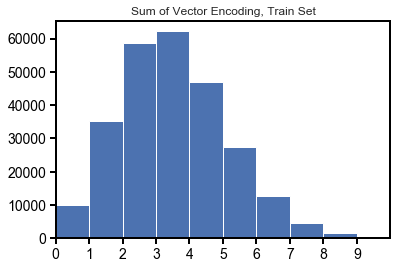

In [7]:
counts_train = [ sum(s) for s in seq_e_train ]
counts_test = [ sum(s) for s in seq_e_test ]

plt.hist(counts_train,bins=12)
plt.xticks(range(10))
plt.xlim(0,10)
plt.title("Sum of Vector Encoding, Train Set")
print 'done'

Text(0.5,1,'Sum of Vector Encoding, Test Set')

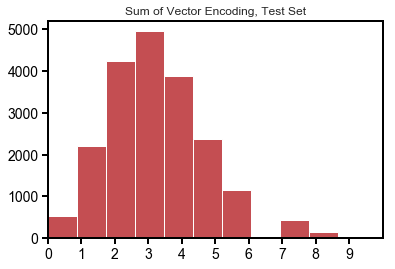

In [8]:
plt.hist(counts_test,bins=15,color='r')
plt.xticks(range(10))
plt.xlim(0,10)
plt.title("Sum of Vector Encoding, Test Set")

In [9]:
e_train.loc[:,'vector_sum'] = counts_train
e_test.loc[:,'vector_sum'] = counts_test

## Create Model Structure (Random Forest) & Train Model

In [10]:
def train_model(train_data,train_labels,n_trees=250,warm_start=True,iterations=5):
    ''' Build model archicture and fit.'''
    model = RandomForestRegressor(n_estimators=n_trees,criterion='mse',warm_start=warm_start)
    n = len(train_data) / iterations
    model.fit(train_data[:n],train_labels[:n])
    for i in range(2,iterations):
        model.fit(train_data[n*(i-1):n*i],train_labels[n*(i-1):n*i])
        model.n_estimators += n_trees
        print model.score(train_data,train_labels)
    return model

In [11]:
rfr1 = train_model(seq_e_train,label_e_train,n_trees=20,iterations=1)
print rfr1.score(seq_e_train,label_e_train), rfr1.score(seq_e_test,label_e_test)

0.49545090801241576 -10.094827708782573


In [12]:
rfr2 = train_model(seq_e_train,label_e_train,n_trees=100,iterations=1)
print rfr2.score(seq_e_train,label_e_train), rfr2.score(seq_e_test,label_e_test)

0.49549474939622584 -10.092544786227599


In [13]:
rfr3 = train_model(seq_e_train,label_e_train,n_trees=2000,iterations=1)
print rfr3.score(seq_e_train,label_e_train), rfr3.score(seq_e_test,label_e_test)

0.49550583672917103 -10.09321471353633


In [14]:
def train_model_sets(train_data_sets,train_label_sets,n_trees=10,warm_start=True):
    ''' Build model archicture and fit.'''
    model = RandomForestRegressor(n_estimators=n_trees,criterion='mse',warm_start=warm_start)
    for data,labels in zip(train_data_sets,train_label_sets):
        model.fit(data,labels)
        model.n_estimators += n_trees
    return model

In [15]:
# Split data so it fits in memory (batch size was 128, going to 130 for even split)
batch_size = 130
train_data_sets = np.split(seq_e_train,(len(seq_e_train)/batch_size))
train_label_sets = np.split(label_e_train,(len(seq_e_train)/batch_size))

In [16]:
rfr5 = train_model_sets(train_data_sets,train_label_sets,n_trees=5,warm_start=True)
print rfr5.score(seq_e_train,label_e_train)
print rfr5.score(seq_e_test,label_e_test)

0.49027502126848177
-10.044064717272834


Notably, the batched 10k model doesn't do as well as the 2000 unit one-shot model!

In [18]:
# This one was a bit too big...
#rfr6 = train_model_sets(train_data_sets,train_label_sets,n_trees=25,warm_start=True)
#print rfr6.score(seq_e_train,label_e_train)
#print rfr6.score(seq_e_test,label_e_test)

In [19]:
# Compute Test r-squared Results
e_test = test_data(e_test,rfr1,seq_e_test,'rl',output_col="20u_pred")
r = r2(e_test['rl'],e_test['20u_pred'])
print r
e_test = test_data(e_test,rfr2,seq_e_test,'rl',output_col="100u_pred")
r = r2(e_test['rl'],e_test['100u_pred'])
print r
e_test = test_data(e_test,rfr3,seq_e_test,'rl',output_col="2000u_pred")
r = r2(e_test['rl'],e_test['2000u_pred'])
print r
e_test = test_data(e_test,rfr5,seq_e_test,'rl',output_col="10ku_split_pred")
r = r2(e_test['rl'],e_test['10ku_split_pred'])
print r

0.5236651478482597
0.5240228779342884
0.5241075956510082
0.5310514935026243


In [20]:
# Compute Train r-squared Results results
e_train = test_data(e_train,rfr1,seq_e_train,'rl',output_col="20u_pred")
r = r2(e_train['rl'],e_train['20u_pred'])
print r
e_train = test_data(e_train,rfr2,seq_e_train,'rl',output_col="100u_pred")
r = r2(e_train['rl'],e_train['100u_pred'])
print r
e_train = test_data(e_train,rfr3,seq_e_train,'rl',output_col="2000u_pred")
r = r2(e_train['rl'],e_train['2000u_pred'])
print r
e_train = test_data(e_train,rfr5,seq_e_train,'rl',output_col="10ku_split_pred")
r = r2(e_train['rl'],e_train['10ku_split_pred'])
print r

0.4954510836015024
0.4954948049741288
0.49550586236557564
0.4906934549625302


In [22]:
# Make Plotting Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

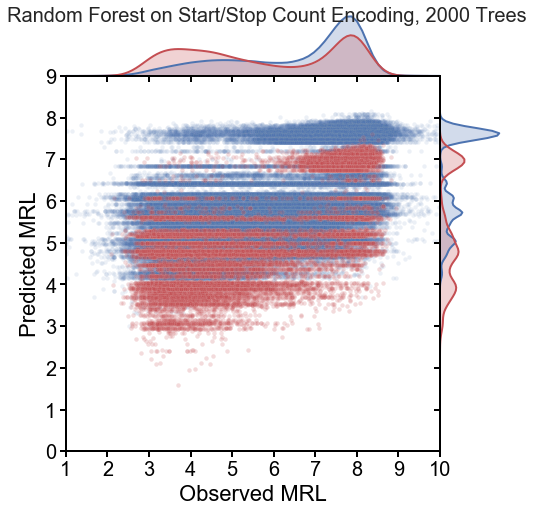

In [47]:
train_test_plot = jointgrid_plot([e_train,e_test],
                                  title='Random Forest on Start/Stop Count Encoding, 2000 Trees',
                                  alphas=[0.1,0.2],
                                  yheader='2000u_pred')

## Create Alternate Datasets Based On Information Content

As per conversation with Stephen and Mike on 9.10, see if the random forest works better on the sequences that have more information, which would suggest that the encoding is the limiting factor, not the random forest's imputation ability

In [24]:
#these are the seqs that have total data more than 3
hi_train_utrs = [ s for e,s in zip(seq_e_train,e_train['utr'].values) if sum(e) > 3 ]
hi_test_utrs = [ s for e,s in zip(seq_e_test,e_test['utr'].values) if sum(e) > 3 ]

train_hi = e_train[ e_train['utr'].isin(hi_train_utrs) ]
test_hi = e_test[ e_test['utr'].isin(hi_test_utrs) ]

In [25]:
seq_test_hi = encode_counts(test_hi)
seq_train_hi = encode_counts(train_hi)

test_hi = test_data(test_hi,rfr3,seq_test_hi,'rl',output_col="2000u_pred")
r = r2(test_hi['rl'],test_hi['2000u_pred'])
train_hi = test_data(train_hi,rfr3,seq_train_hi,'rl',output_col="2000u_pred")
r = r2(train_hi['rl'],train_hi['2000u_pred'])

test_hi = test_data(test_hi,rfr5,seq_test_hi,'rl',output_col="10ku_split_pred")
r = r2(test_hi['rl'],test_hi['10ku_split_pred'])
train_hi = test_data(train_hi,rfr5,seq_train_hi,'rl',output_col="10ku_split_pred")
r = r2(train_hi['rl'],train_hi['10ku_split_pred'])

In [26]:
train_hi.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(train_hi.loc[:,'rl'].values.reshape(-1,1))

In [27]:
rfr_hi = train_model(seq_train_hi,train_hi['scaled_rl'].values,n_trees=2000,iterations=1)
print rfr_hi.score(seq_train_hi,train_hi['rl']), rfr_hi.score(seq_test_hi,test_hi['rl'])

-12.809391686373361 -9.959463621516555


In [28]:
test_hi = test_data(test_hi,rfr_hi,seq_test_hi,'rl',output_col="2000u_hi_pred")
r = r2(test_hi['rl'],test_hi['2000u_hi_pred'])
train_hi = test_data(train_hi,rfr_hi,seq_train_hi,'rl',output_col="2000u_hi_pred")
r = r2(train_hi['rl'],train_hi['2000u_hi_pred'])

In [29]:
e_test = test_data(e_test,rfr_hi,seq_e_test,'rl',output_col="2000u_hi_pred")
r = r2(e_test['rl'],e_test['2000u_hi_pred'])
print r
e_train = test_data(e_train,rfr_hi,seq_e_train,'rl',output_col="2000u_hi_pred")
r = r2(e_train['rl'],e_train['2000u_hi_pred'])
print r

0.5292844532627973
0.4907826544245854


### Does Testing and/or Training on the High-Vector-Sum Data Improve Results?

In [30]:
r = r2(e_train['rl'],e_train['2000u_hi_pred'])
print "High-trained RFR on Full Train Data", "\t", r
r = r2(e_train['rl'],e_train['2000u_pred'])
print "Normal RFR on Full Train Data","\t\t",r
r = r2(e_test['rl'],e_test['2000u_hi_pred'])
print "High-trained RFR on Full Test Data","\t", r
r = r2(e_test['rl'],e_test['2000u_pred'])
print "Normal RFR on Full Test Data","\t\t",r
print
r = r2(train_hi['rl'],train_hi['2000u_hi_pred'])
print "High-trained RFR on High Train Data","\t", r
r = r2(train_hi['rl'],train_hi['2000u_pred'])
print "Normal RFR on High Train Data","\t\t",r
r = r2(test_hi['rl'],test_hi['2000u_hi_pred'])
print "High-trained RFR on High Test Data","\t", r
r = r2(test_hi['rl'],test_hi['2000u_pred'])
print "Normal RFR on High Test Data","\t\t",r


High-trained RFR on Full Train Data 	0.4907826544245854
Normal RFR on Full Train Data 		0.49550586236557564
High-trained RFR on Full Test Data 	0.5292844532627973
Normal RFR on Full Test Data 		0.5241075956510082

High-trained RFR on High Train Data 	0.4273725981199346
Normal RFR on High Train Data 		0.42737438583284826
High-trained RFR on High Test Data 	0.39797493674561796
Normal RFR on High Test Data 		0.3980551084460666


### ANSWER: Not Really

Can we see what this looks like in more detail with plotting?  


From the plots, it looks like for the very high-info UTRs (aka vector sum 9+), they are distinctly more lying-along-the-y=x-line (aka accurate) than the lower-info UTRs, so it might be that total info matters in the extreme case, but is not predictive for the bulk of the sequences? See trend in yellow vs blue vs purple data, several graphs down)

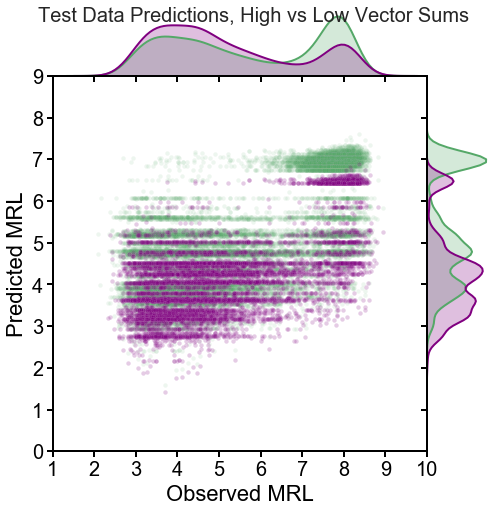

In [49]:
p = jointgrid_plot([e_test,test_hi],
                                  title='Test Data Predictions, High vs Low Vector Sums',
                                  colors=['g','purple'],
                                  alphas=[0.1,0.2],
                                  yheader='2000u_pred')

Nope, doesn't seem like the high vector sum test set is any more successful.


### What if we plot stratified by Vector Sum?

Lots of plots to follow

In [32]:
data = pd.concat([e_test,e_train],axis=0)
data.head(2)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,10,100u_pred,10ku_split_pred,11,12,13,2,2000u_hi_pred,...,r6,r7,r8,r9,rl,scaled_rl,total,total_reads,utr,vector_sum
0,0.000137,0.000109,0.000015,5.207805,5.212045,0.000015,0.000013,0.000017,0.000057,5.740599,...,0.020343,0.019850,0.017988,0.019283,3.039939,NaN,0.000463,12126.0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.0
1,0.000067,0.000070,0.000016,3.899211,3.939142,0.000016,0.000016,0.000015,0.000065,4.735933,...,0.028540,0.027431,0.024766,0.024241,3.895109,NaN,0.000395,10368.0,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,2.0


In [33]:
e =  encode_counts(data)
z = [ s for i,s in enumerate(data['utr'].values) if np.sum(e[i]) < 1 ]
data_zeros = data[ data['utr'].isin(z) ]
data_nonzero = data[ ~data['utr'].isin(data_zeros['utr'].values)]

ns = [ s for i,s in enumerate(data['utr'].values) if (e[i][0]+e[i][1]) < 1 ]
nt = [ s for i,s in enumerate(data['utr'].values) if (e[i][2]+e[i][3]) < 1 ]
data_nostart = data[ data['utr'].isin(ns) ]
data_nostop = data[ data['utr'].isin(nt) ]
data_rest = data[ ~data['utr'].isin(ns+nt) ]

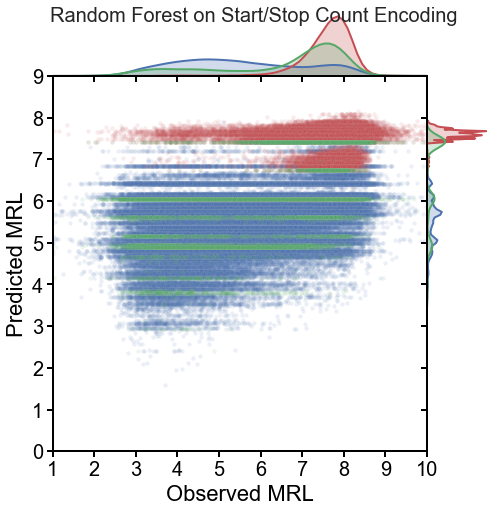

In [34]:
train_test_plot2 = jointgrid_plot([data_rest,data_nostart,data_nostop],
                                  title='Random Forest on Start/Stop Count Encoding',
                                  colors = ['b','r','g'],
                                  yheader='2000u_pred')

In [35]:
e_train.loc[:,'2000u_error'] = np.abs(e_train['2000u_pred'] - e_train['rl']) / e_train['rl'] 
e_test.loc[:,'2000u_error'] = np.abs(e_test['2000u_pred'] - e_test['rl']) / e_test['rl'] 
data.loc[:,'2000u_error'] = np.abs(data['2000u_pred'] - data['rl']) / data['rl']

In [36]:
# numbers = [ data[data['vector_sum'] == i ] for i in range(14)]
# train_test_plot2 = jointgrid_plot(numbers,
#                                   title='Random Forest on Start/Stop Count Encoding, Colored by Total Information',
#                                   colors = ['crimson','r','orange','gold','limegreen','g','dodgerblue',
#                                             'b','blueviolet','purple','mediumvioletred','slategrey','black'],
#                                   yheader='2000u_pred')

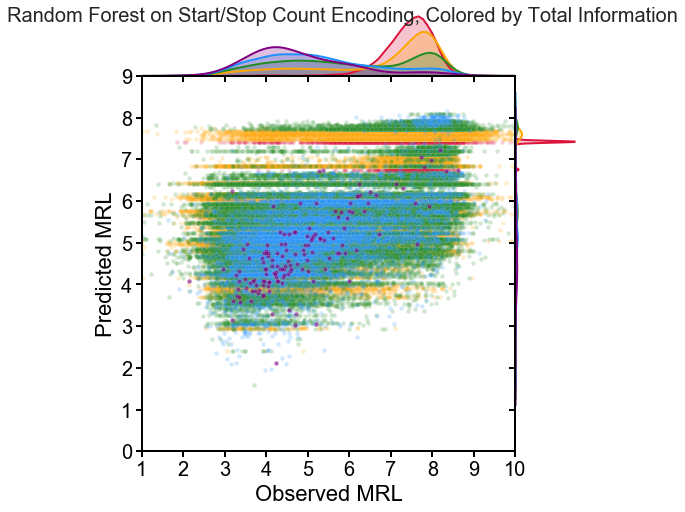

In [37]:
numbers2 = [ data[data['vector_sum'].isin(t) ] for t in [ (0,0,0),(1,2,3),(4,5,6),(7,8,9),(10,11,12,13) ] ]
train_test_plot2 = jointgrid_plot(numbers2,
                                  title='Random Forest on Start/Stop Count Encoding, Colored by Total Information',
                                  colors = ['crimson','orange','forestgreen','dodgerblue','purple',],
                                  alphas = [ 0.2,0.2,0.2,0.2,0.6],
                                  yheader='2000u_pred')

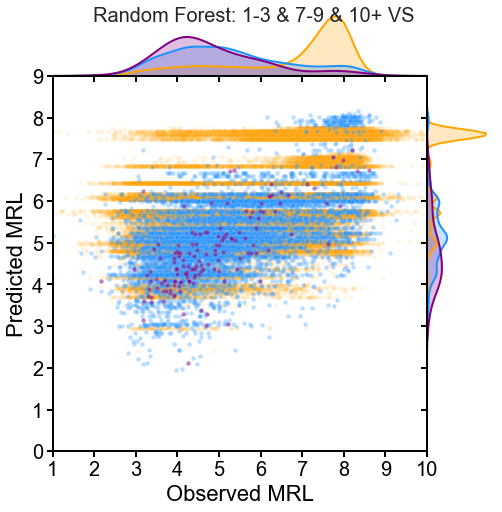

In [38]:
train_test_plot2 = jointgrid_plot([numbers2[1],numbers2[3],numbers2[4]],
                                  title='Random Forest: 1-3 & 7-9 & 10+ VS',
                                  colors = ['orange', 'dodgerblue','purple'],
                                  alphas=[0.1, 0.3,0.5],
                                  yheader='2000u_pred')

(0, 1)

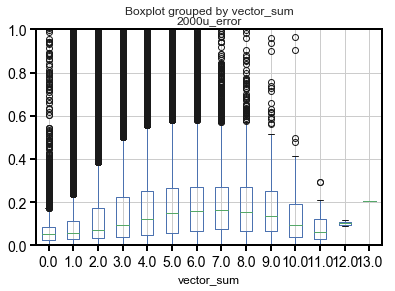

In [39]:
box = data.boxplot(column='2000u_error',by='vector_sum')
box.set_ylim(0,1)

### Yeah, this seems pretty inconclusive. I don't think the PRIMARY driver of prediction quality is vector sum, here, but it does seem like if you have a LARGE amount of data your error is lower.


now, on to the next question...  


# Is this the best the Encoding can do, or is the limit the RF?

Try training a Neural Network with the same encoding to see if it can do better, and if so how much

In [40]:
import keras
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

Using TensorFlow backend.


In [42]:
# build the NN model
nn = Sequential()
nn.add(Dense(500,input_shape=(4,)))
nn.add(Activation('relu'))
nn.add(Dropout(0))
nn.add(Dense(100))
nn.add(Activation('relu'))
nn.add(Dropout(0.1))
nn.add(Dense(50))
nn.add(Activation('relu'))
nn.add(Dropout(0.1))
    
nn.add(Dense(1))
nn.add(Activation('linear'))

np.random.seed(1337)

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
nn.compile(loss='mean_squared_error', optimizer=adam)

#fit the model
nn.fit(seq_e_train, e_train['scaled_rl'], batch_size=128, epochs=10, verbose=1)

Epoch 1/10
260000/260000 [==============================] - 6s 22us/step - loss: 0.5200
Epoch 2/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5137
Epoch 3/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5127
Epoch 4/10
260000/260000 [==============================] - 5s 21us/step - loss: 0.5120
Epoch 5/10
260000/260000 [==============================] - 5s 21us/step - loss: 0.5117
Epoch 6/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5117
Epoch 7/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5111
Epoch 8/10
260000/260000 [==============================] - 5s 19us/step - loss: 0.5109
Epoch 9/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5109
Epoch 10/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.5108


In [43]:
e_test = test_data(e_test,nn,seq_e_test,'rl',output_col="nn_pred")
r = r2(e_test['rl'],e_test['nn_pred'])
print r
e_train = test_data(e_train,nn,seq_e_train,'rl',output_col='nn_pred')
r = r2(e_train['rl'],e_train['nn_pred'])
print r

0.5217960787416644
0.493890539453438


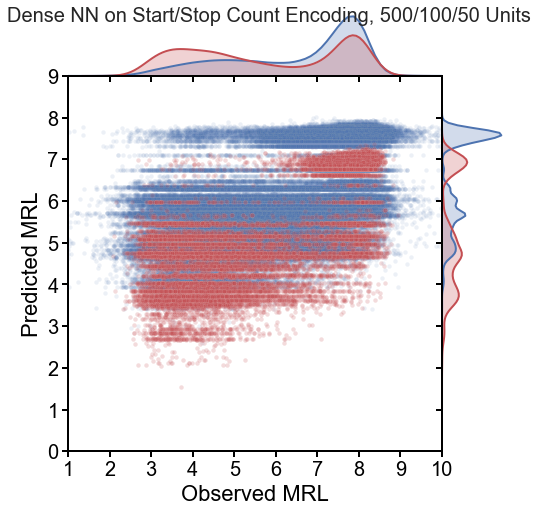

In [45]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='Dense NN on Start/Stop Count Encoding, 500/100/50 Units',
                                  alphas=[0.1,0.2],
                                  yheader='nn_pred')

## ANSWER: Seems like the encoding is the bottleneck?

Encoding doesn't appear to have enough information to generalize well; or at least, with this particular encoding, a 3-layer dense neural network (500, 100, and 50 neurons per layer) trained for 10 epochs with 0, 0.1, and 0.2 dropout does not perform appreciably better on either the test or train dataset than a Random Forest Regressor with 2000 trees. The loss during training rapidly reaches about 0.52 in the second epoch and does not decrease appreciably from there for the rest of training, suggesting the limit in the encoding has been reached


Interestingly, the test data looks much more linear than the train data, with that upper off-diagonal chunk messing up the r2...

## Try to do One-Hot Encoding with an RFR

Looking at Kangway's notebooks for a model of how to do it...

In [50]:
y_train = label_e_train
y_test = label_e_test

In [52]:
# One-Hot Base Pair Encoding, All on One Line
nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}


X_train_cnn = np.empty([len(e_train),50*4,1])
X_test_cnn = np.empty([len(e_test),50*4,1])
X_train_cnn2 = np.empty([len(e_train),1,50*4]) #try the other shape for vector encoding, in case that is relevant?
X_test_cnn2 = np.empty([len(e_test),1,50*4])   # see the examples below 
X_train_rfr = np.empty([len(e_train),50*4])
X_test_rfr = np.empty([len(e_test),50*4])


for i,seq in enumerate(e_train['utr'].values): 
    seq = seq.upper()
    a = np.array([nuc_d[x] for x in seq]).flatten()
    X_train_rfr[i] = a
    X_train_cnn[i] = a.reshape(200,1)
    X_train_cnn2[i] = a.reshape(1,200)
for i,seq in enumerate(e_test['utr'].values): 
    seq = seq.upper()
    a = np.array([nuc_d[x] for x in seq]).flatten()
    X_test_rfr[i] = a
    X_test_cnn[i] = a.reshape(200,1)
    X_test_cnn2[i] = a.reshape(1,200)


In [54]:
#Encoding Example
a = ['GGG','TAT']
vectors = np.empty([2,1,3*4])
for i,s in enumerate(a):
    print s
    b = np.array([nuc_d[x] for x in s])
    print b
    print "Flat", b.flatten()
    print "1xN", b.reshape(1,12)
    print "Nx1", b.reshape(12,1)
    print

GGG
[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
Flat [0 0 1 0 0 0 1 0 0 0 1 0]
1xN [[0 0 1 0 0 0 1 0 0 0 1 0]]
Nx1 [[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]]

TAT
[[0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]]
Flat [0 0 0 1 1 0 0 0 0 0 0 1]
1xN [[0 0 0 1 1 0 0 0 0 0 0 1]]
Nx1 [[0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]



In [57]:
# build the CNN model
cnn = Sequential()

cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=60, 
                 kernel_size=24,strides=4) ) #strides=4 b/c want to go forwards one bp at a time, aka 4 places
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 

cnn.add(Flatten())
cnn.add(Dense(30))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
    
cnn.add(Dense(1))
cnn.add(Activation('linear'))


In [58]:
np.random.seed(1337)

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
cnn.compile(loss='mean_squared_error', optimizer=adam)

# fit the model
cnn.fit(X_train_cnn, y_train, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
260000/260000 [==============================] - 35s 135us/step - loss: 0.2741
Epoch 2/10
260000/260000 [==============================] - 36s 138us/step - loss: 0.1471
Epoch 3/10
260000/260000 [==============================] - 36s 139us/step - loss: 0.1366
Epoch 4/10
260000/260000 [==============================] - 35s 134us/step - loss: 0.1317
Epoch 5/10
260000/260000 [==============================] - 34s 131us/step - loss: 0.1288
Epoch 6/10
260000/260000 [==============================] - 36s 137us/step - loss: 0.1257
Epoch 7/10
260000/260000 [==============================] - 36s 140us/step - loss: 0.1227
Epoch 8/10
260000/260000 [==============================] - 34s 129us/step - loss: 0.1208
Epoch 9/10
260000/260000 [==============================] - 36s 139us/step - loss: 0.1188
Epoch 10/10
260000/260000 [==============================] - 36s 140us/step - loss: 0.1175


In [65]:
e_test = test_data(e_test,cnn,X_test_cnn,'rl',output_col="cnn_pred")
r = r2(e_test['rl'],e_test['cnn_pred'])
print r
e_train = test_data(e_train,cnn,X_train_cnn,'rl',output_col="cnn_pred")
r = r2(e_train['rl'],e_train['cnn_pred'])
print r

0.9369445127649163
0.9086254941312525


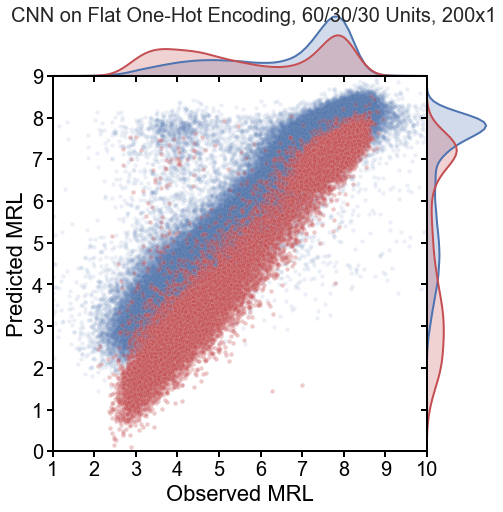

In [66]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='CNN on Flat One-Hot Encoding, 60/30/30 Units, 200x1',
                                  alphas=[0.1,0.3],
                                  yheader='cnn_pred')

In [67]:
# Try the other vector shape, just to check!
cnn2 = Sequential()
cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
                 padding="same", filters=60, 
                 kernel_size=24,strides=4) ) #strides=4 b/c want to go forwards one bp at a time, aka 4 places
cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn2.add(Flatten())
cnn2.add(Dense(30))
cnn2.add(Activation('relu'))
cnn2.add(Dropout(0.2))
cnn2.add(Dense(1))
cnn2.add(Activation('linear'))

In [68]:
np.random.seed(1337)

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
cnn2.compile(loss='mean_squared_error', optimizer=adam)

# fit the model
cnn2.fit(X_train_cnn2, y_train, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
260000/260000 [==============================] - 22s 84us/step - loss: 0.9187
Epoch 2/10
260000/260000 [==============================] - 21s 80us/step - loss: 0.8354
Epoch 3/10
260000/260000 [==============================] - 18s 70us/step - loss: 0.7770
Epoch 4/10
260000/260000 [==============================] - 20s 78us/step - loss: 0.7111
Epoch 5/10
260000/260000 [==============================] - 21s 82us/step - loss: 0.6489
Epoch 6/10
260000/260000 [==============================] - 17s 67us/step - loss: 0.5788
Epoch 7/10
260000/260000 [==============================] - 18s 70us/step - loss: 0.5180
Epoch 8/10
260000/260000 [==============================] - 18s 70us/step - loss: 0.4681
Epoch 9/10
260000/260000 [==============================] - 18s 68us/step - loss: 0.4288
Epoch 10/10
260000/260000 [==============================] - 18s 68us/step - loss: 0.4077


0.6993212225565746
0.6360561800224303


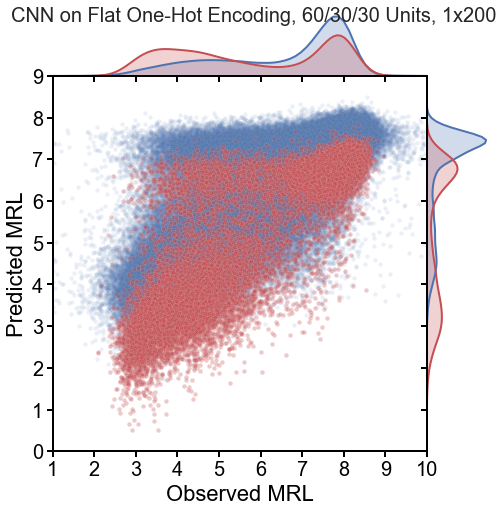

In [69]:
e_test = test_data(e_test,cnn2,X_test_cnn2,'rl',output_col="cnn2_pred")
r = r2(e_test['rl'],e_test['cnn2_pred'])
print r
e_train = test_data(e_train,cnn2,X_train_cnn2,'rl',output_col="cnn2_pred")
r = r2(e_train['rl'],e_train['cnn2_pred'])
print r

train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='CNN on Flat One-Hot Encoding, 60/30/30 Units, 1x200',
                                  alphas=[0.1,0.3],
                                  yheader='cnn2_pred')

#### I see, 200x1 vs 1x200 is VERY different. Interesting!

Wow, the 200x1 is as good or better than their CNN, just as a note. Hmm cool.

In [70]:
#Save NN Models
nn.save('./saved_models/3lCountEncode_nn.hdf5')
cnn.save('./saved_models/4lFlatOneHotEncode_cnn.hdf5')
cnn2.save('./saved_models/4lFlatOneHotEncode2_cnn.hdf5')

## Now Try Random Forest With Same Encoding

In [71]:
np.random.seed(1337)
rfr_mini = RandomForestRegressor(n_estimators=5,criterion='mse',warm_start=True,verbose=1)
rfr_mini.fit(X_train_rfr,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

In [72]:
np.random.seed(1337)
rfr_small = RandomForestRegressor(n_estimators=10,criterion='mse',warm_start=True,verbose=1)
rfr_small.fit(X_train_rfr,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

In [73]:
e_test = test_data(e_test,rfr_mini,X_test_rfr,'rl',output_col="rfrm_pred")
r = r2(e_test['rl'],e_test['rfrm_pred'])
print r
e_train = test_data(e_train,rfr_mini,X_train_rfr,'rl',output_col="rfrm_pred")
r = r2(e_train['rl'],e_train['rfrm_pred'])
print r
e_test = test_data(e_test,rfr_small,X_test_rfr,'rl',output_col="rfrs_pred")
r = r2(e_test['rl'],e_test['rfrs_pred'])
print r
e_train = test_data(e_train,rfr_small,X_train_rfr,'rl',output_col="rfrs_pred")
r = r2(e_train['rl'],e_train['rfrs_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


0.09062406534904013


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


0.7989225882910329


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


0.13705887808696693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


0.8815788999493119


## Whaaaaat is going on here? Why are the test sets wayyy worse, like 0.8 r2 apart??

Also really interesting, if indeed this plot is valid and I didn't make some code error somewhere, is that the off-diagonal points are NONEXISTANT

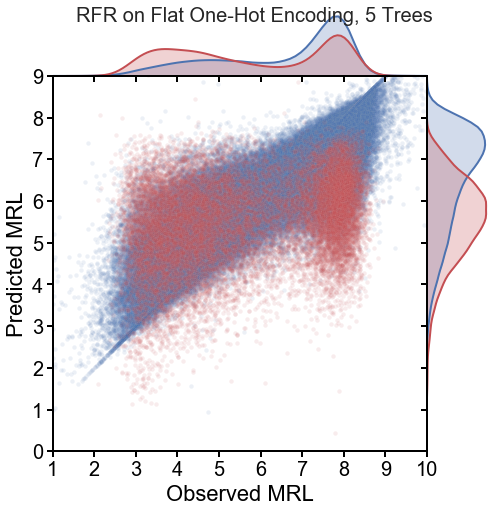

In [74]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 5 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfrm_pred')

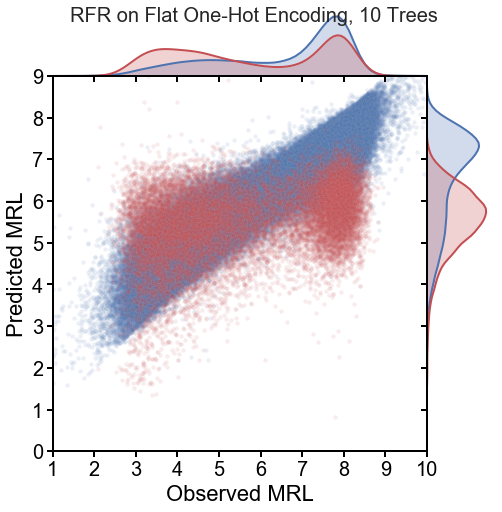

In [75]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 10 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfrs_pred')

## What does this look like with MORE trees?

In [76]:
np.random.seed(1337)
rfr = RandomForestRegressor(n_estimators=100,criterion='mse',verbose=1)
rfr.fit(X_train_rfr,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [77]:
e_test = test_data(e_test,rfr,X_test_rfr,'rl',output_col="rfr_pred")
r = r2(e_test['rl'],e_test['rfr_pred'])
print r
e_train = test_data(e_train,rfr,X_train_rfr,'rl',output_col="rfr_pred")
r = r2(e_train['rl'],e_train['rfr_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished


0.23850296946528154


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished


0.9721581053308644


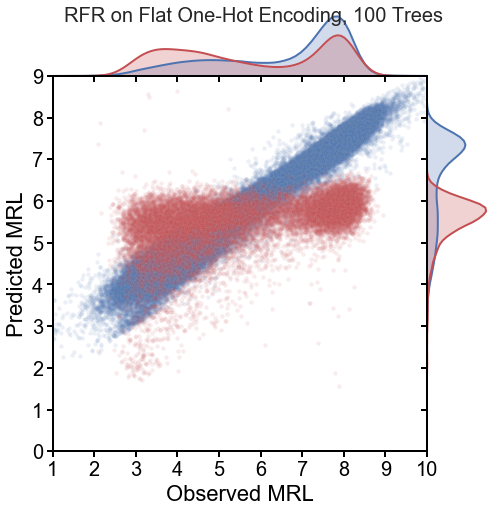

In [78]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 100 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfr_pred')

In [79]:
import pickle
# Save RFRs
pickle.dump(rfr, open('./saved_models/100treeOH_rfr.sav', 'wb'))
pickle.dump(rfr_small, open('./saved_models/10treeOH_rfr.sav', 'wb'))
pickle.dump(rfr_mini, open('./saved_models/5treeOH_rfr.sav', 'wb'))
pickle.dump(rfr5, open('./saved_models/10ktreeVC_rfr.sav', 'wb'))
pickle.dump(rfr3, open('./saved_models/2ktreeVC_rfr.sav', 'wb'))

In [88]:
one_tree = rfr_mini.estimators_[0]

from sklearn.tree import export_graphviz
import os

# Export as dot file
export_graphviz(one_tree, out_file='./plots/5trOH_rfr_tr0.dot', 
                max_depth=10,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


## couldn't get dotfile conversion to png to work...

#os.system('dot -Tpng ./plots/5trOH_rfr.dot -o ./plots/5trOH_rfr.png -Gdpi=600')

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', './plots/5trOH_rfr_tr0.dot', '-o', './plots/5trOH_rfr_tr0.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = './plots/5trOH_rfr_tr0.png')